In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import collections



In [7]:
# df = pd.read_csv('../data/raw/train_values.csv')
# df.dtypes

In [8]:
import pandas as pd

def load_data():
    try:
        df_train_X = pd.read_csv('../data/raw/train_values.csv')
        df_train_y = pd.read_csv('../data/raw/train_labels.csv')
        df_test_X = pd.read_csv('../data/raw/test_values.csv')
    except FileNotFoundError:
        print("Error: File not found. Please check the file path.")

    nrows_train = df_train_X.shape[0]
    nrows_test = df_test_X.shape[0]
    nrows_tot = nrows_train+nrows_test

    df_train_X['train'] = 1
    df_test_X['train'] = 0
    df_X = pd.concat([df_train_X, df_test_X], ignore_index=True)
    df = pd.merge(df_X, df_train_y, on='building_id', how='left')

    assert df.shape[0]==nrows_tot, "Incorrect number of rows"
    assert isinstance(df, pd.DataFrame), "No pandas dataframe returned"

    return df


In [6]:
# def plot_distributions(df, cols_per_row=3):
#     num_cols = len(df.columns)
#     num_rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)  # Calculate number of rows
    
#     fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(5 * cols_per_row, 4 * num_rows))
#     axes = axes.flatten()  # Flatten in case of multiple rows

#     for i, col in enumerate(df.columns):
#         sns.histplot(df[col].dropna(), kde=False, ax=axes[i])
#         axes[i].set_title(f'Distribution of {col}')
    
#     # Hide unused subplots (if any)
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

# plot_distributions(df)


In [16]:
# categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'foundation_type', 'ground_floor_type', 'other_floor_type']
# df_onehot = pd.get_dummies(df, columns=categorical_features)
# print(df_onehot.head())

In [29]:
import pandas as pd

def do_encoding(df):
    df = convert_numerical_to_categorical(df)
    df = target_encoding(df)
    return df

def convert_numerical_to_categorical(df):
    numerical_columns_to_convert = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    for col in numerical_columns_to_convert:
        df[col] = df[col].astype(str)  # Convert to string (categorical)
    return df
def target_encoding(df):
    target_col = 'damage_grade'
    df_encoded = df.copy()

    # Encode categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        df_encoded[f"{col} t-enc mean"] = df.groupby(col)[target_col].transform('mean')
        df_encoded[f"{col} t-enc std"] = df.groupby(col)[target_col].transform('std')

    df_encoded.drop(columns=categorical_cols, inplace=True, errors='ignore')  # Drop safely

    # Function for encoding binary combinations
    def encode_combination(df, col_prefix, target_col, new_col_name):
        df_local = df.copy()
        cols = df_local.filter(like=col_prefix).columns
        
        if len(cols) == 0:  # If no matching columns, return original dataframe
            return df_local

        combination_key = df_local[cols].astype(str).agg(''.join, axis=1)
        df_local[f"{new_col_name} mean"] = combination_key.map(df_local.groupby(combination_key)[target_col].transform('mean'))
        df_local[f"{new_col_name} std"] = combination_key.map(df_local.groupby(combination_key)[target_col].transform('std'))

        return df_local.drop(columns=cols)

    df_encoded = encode_combination(df_encoded, 'has_superstructure', target_col, 'superstructure t-enc')
    df_encoded = encode_combination(df_encoded, 'has_secondary_use', target_col, 'secondary_usage t-enc')

    return df_encoded



<Axes: >

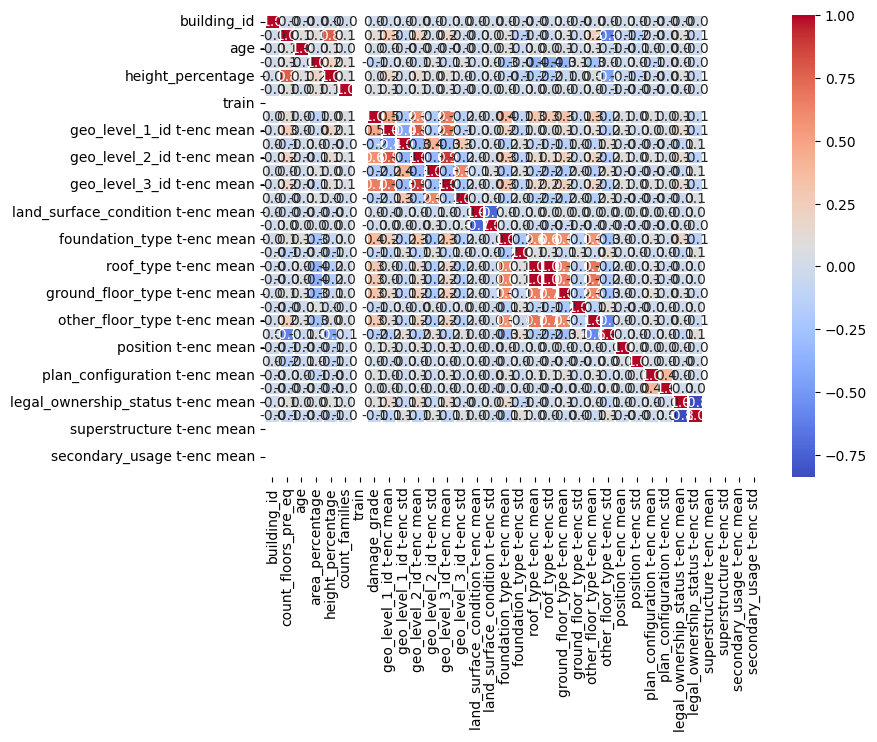

In [30]:
df = load_data()
df = df[df['train']==1]
dfe = do_encoding(df)
corr_matrix = dfe.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".1f", linewidths=0.25)

In [35]:
print(dfe.columns)

Index(['building_id', 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage', 'count_families', 'train', 'damage_grade',
       'geo_level_1_id t-enc mean', 'geo_level_1_id t-enc std',
       'geo_level_2_id t-enc mean', 'geo_level_2_id t-enc std',
       'geo_level_3_id t-enc mean', 'geo_level_3_id t-enc std',
       'land_surface_condition t-enc mean', 'land_surface_condition t-enc std',
       'foundation_type t-enc mean', 'foundation_type t-enc std',
       'roof_type t-enc mean', 'roof_type t-enc std',
       'ground_floor_type t-enc mean', 'ground_floor_type t-enc std',
       'other_floor_type t-enc mean', 'other_floor_type t-enc std',
       'position t-enc mean', 'position t-enc std',
       'plan_configuration t-enc mean', 'plan_configuration t-enc std',
       'legal_ownership_status t-enc mean', 'legal_ownership_status t-enc std',
       'superstructure t-enc mean', 'superstructure t-enc std',
       'secondary_usage t-enc mean', 'secondary_usage t-enc 

In [ ]:
# geo_level_1_id t-enc 

In [ ]:
dfe['geo_foundation_combo'] = dfe['geo_level_1_id t-enc mean'].astype(str) + "_" + \
                              dfe['geo_level_2_id t-enc mean'].astype(str) + "_" + \
                              dfe['geo_level_3_id t-enc mean'].astype(str) + "_" + \
                              df['foundation_type'].astype(str)

dfe['geo_foundation_encoded'] = dfe.groupby('geo_foundation_combo')['damage_grade'].transform('mean')

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

geo_feats = ['geo_level_1_id t-enc mean', 'geo_level_2_id t-enc mean', 'geo_level_3_id t-enc mean', 'foundation_type']

# Encode the foundation_type column
le = LabelEncoder()
df['foundation_type_encoded'] = le.fit_transform(df['foundation_type'])

# Use the encoded foundation_type for clustering
geo_feats_encoded = ['geo_level_1_id t-enc mean', 'geo_level_2_id t-enc mean', 'geo_level_3_id t-enc mean', 'foundation_type_encoded']
dfe[geo_feats_encoded] = dfe[geo_feats_encoded].astype(float)  # Ensure numeric values for clustering

kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust clusters as needed
dfe['geo_foundation_cluster'] = kmeans.fit_predict(dfe[geo_feats_encoded])

In [43]:
dfe['geo1_foundation_interaction'] = dfe['geo_level_1_id t-enc mean'] * df['foundation_type'].astype('category').cat.codes
dfe['geo2_foundation_interaction'] = dfe['geo_level_2_id t-enc mean'] * df['foundation_type'].astype('category').cat.codes
dfe['geo3_foundation_interaction'] = dfe['geo_level_3_id t-enc mean'] * df['foundation_type'].astype('category').cat.codes

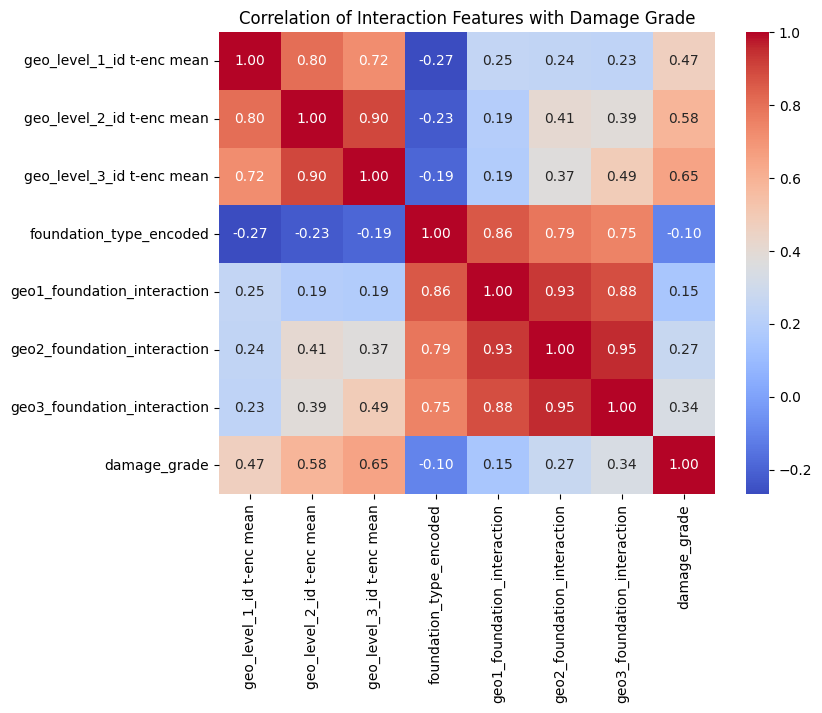

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

interaction_features = ['geo_level_1_id t-enc mean', 'geo_level_2_id t-enc mean', 'geo_level_3_id t-enc mean', 
                        'foundation_type_encoded', 'geo1_foundation_interaction','geo2_foundation_interaction', 'geo3_foundation_interaction' ]

df_corr = dfe[interaction_features + ['damage_grade']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Interaction Features with Damage Grade")
plt.show()



In [46]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Define the features and target
features = ['geo_level_1_id t-enc mean', 'geo_level_2_id t-enc mean', 'geo_level_3_id t-enc mean', 
            'foundation_type_encoded', 'geo1_foundation_interaction', 'geo2_foundation_interaction', 
            'geo3_foundation_interaction']
target = 'damage_grade'

# Prepare the data
X = dfe[features]
y = dfe[target]

# Train a RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                             importance
geo_level_3_id t-enc mean      0.347269
geo3_foundation_interaction    0.212938
geo_level_2_id t-enc mean      0.194450
geo2_foundation_interaction    0.106874
geo1_foundation_interaction    0.055290
geo_level_1_id t-enc mean      0.052949
foundation_type_encoded        0.030231


In [24]:
# print(df['geo_foundation_combo'].nunique())  # Check unique categories
# print(df['geo_foundation_encoded'].describe())  # Check distribution of encoded values
# print(df['geo_foundation_cluster'].value_counts())  # See cluster sizes


# import matplotlib.pyplot as plt
# import seaborn as sns

# # Scatter plot of clusters based on geo & foundation
# sns.scatterplot(x=df['geo_level_1_id'], y=df['geo_level_2_id'], hue=df['geo_foundation_cluster'], palette="viridis")
# plt.title("Geo-Foundation Clusters")
# plt.show()

# print(df[['geo_foundation_encoded', 'geo_foundation_cluster', 'damage_grade']].corr())



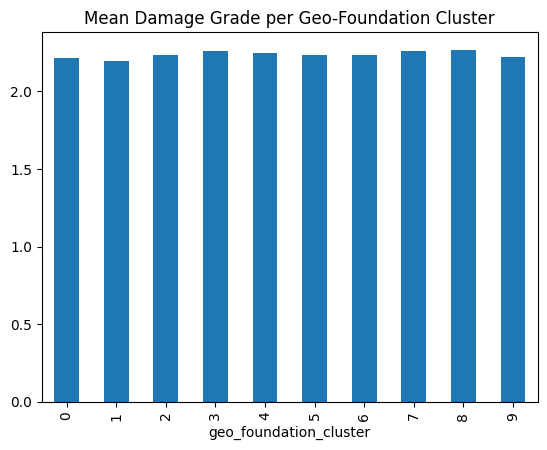

In [23]:



df.groupby('geo_foundation_cluster')['damage_grade'].mean().plot(kind='bar')
plt.title("Mean Damage Grade per Geo-Foundation Cluster")
plt.show()